# How to Perform Multivariate Outlier Detection in Python PyOD For Machine Learning
## Outlier detection series, part 3
![](images/unsplash.jpg)

<figcaption style="text-align: center;"><figcaption/>
Photo by <a href="https://unsplash.com/@miyatankun?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Takashi Miyazaki</a> on <a href="https://unsplash.com/backgrounds/art/abstract?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

### Motivation

Below is a *very* suspicious boxplot:

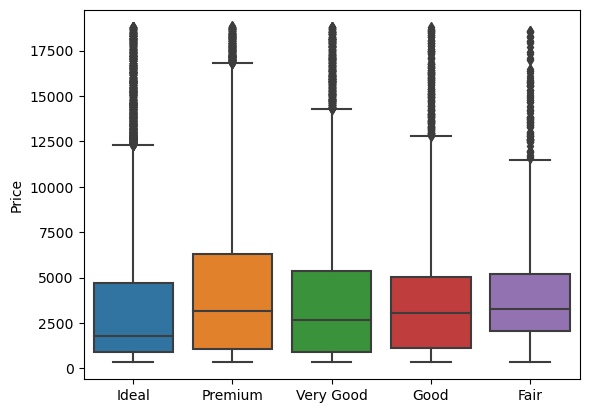

It depicts the relationship between diamonds' quality and their price. The six quality categories are given in the descending order, so the best diamonds are in the *Ideal* and the lowest quality diamonds are in the *Fair* category. 

Now, here are the strange parts. First, all categories have many outliers, marked with dark spots above the whiskers. 

Second, even though Ideal diamonds are supposed to be the best, their median price is lower than any other category (the median is given as the line inside the boxes).

This strange relationship between diamond qualities and their prices begs us the question: are those outliers *actually* outliers?

Today, we will answer that exact question or in other words, we will learn how to differentiate multivariate outliers and how we can detect them.

This is the third part of our outlier detection series. Check out the first two below:

### More on multivariate outliers

In the first part of our series, we made the following points.

Univariate outliers, as the name suggests, only exist in single distributions or individual columns of datasets. They are much easier to detect with methods like z-scores or Median Absolute Deviation. An example is an extremely tall person in a dataset that records only people's heights (single column).

Multivariate outliers are harder to find as they usually emerge when you look at many columns of the dataset simultaneously. 

For example, let's say we have a dataset of hospital records. Its columns are the physical characteristics of patients and the type of disease they have. Now, we are looking at Henry's records:

Age: 18
Height: 178 cm
Weight: 65 kg
Non-smoker: Yes
Disease: Lung cancer

If we consider Henry's attributes individually, they seem totally ordinary within the context of our dataset. There are many 18 year-olds, there are many people that are 178 cm tall or weigh 65 kgs in our dataset. 

Also, there are many non-smoking 18-year-olds or people with lung cancer in the hospital. BUT, we do NOT have any non-smoking 18-year-olds with lung cancer that weigh 65 kg and are 178 cm tall.

The fact that Henry was a mutlivaraite outlier came into light only when we considered all his physical attributes simultaneously. 

Now, similar cases of Henry's might emerge across dozens or even hundreds of attributes in a dataset. Therefore, it is imperative we learn more sophisticated methods to detect multivariate outliers.

This is where machine learning methods, more specifically, outlier classifiers come into play.

### Loading the dataset

Let's first load the dataset we will be working with. It is the same Diamonds dataset from the last tutorial:

```python
import seaborn as sns 

diamonds = sns.load_dataset("diamonds")
diamonds.head()
```

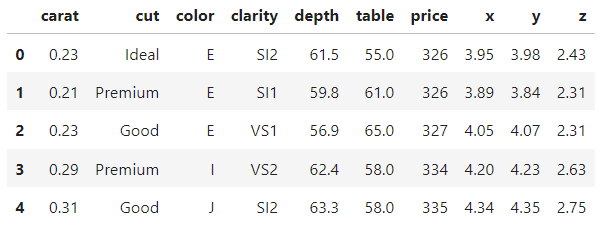

We perform a small preprocessing step where encode the categoricals with the OrdinalEncoder class of Sklearn:

In [2]:
import numpy as np
from sklearn.preprocessing import OrdinalEncoder

# Extract feature and target arrays
X, y = diamonds.drop("carat", axis=1), diamonds["carat"]
# Select categorical column names
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Encode categoricals
X.loc[:, cats] = OrdinalEncoder().fit_transform(X[cats])

Now, let's begin! (rubs hands together)

### Multivariate outlier detection with PyOD

Even though the theory may be a bit hard, performing multivariate outlier detection in code is very easy thanks to the Python Outlier Detection (PyOD) library. Let's see an example using the Local Outlier Factor algorithm:

In [5]:
# Import LOF
from pyod.models.lof import LOF

# Initialize
lof = LOF(n_neighbors=30).fit(X)

# Extract inlier/outlier labels
labels = lof.labels_
outliers_X_lof = X[labels == 1]

After importing the `LOF` estimator from `pyod`, we initialize it with 30 neighbors and fit to `X` (don't worry about the details of `LOF`, we'll talk about that later).

Then, we access its `labels_` attribute, which returns 0 (inliers) or 1 (outliers) for each row of `X`. Let's count the outliers:

In [6]:
num_outliers = len(outliers_X_lof)
print(f"The number of outliers: {num_outliers}")
print(f"Percentage of outliers: {num_outliers / len(X):.3f}")

The number of outliers: 5394
Percentage of outliers: 0.100


Hmm, we have got 5394 outliers or exactly 10% of the dataset. Is this a coincidence? Let's try the same operation with another outlier classifier, Isolation Forest:

In [8]:
from pyod.models.iforest import IForest

iforest = IForest(n_estimators=500).fit(X)

labels = iforest.labels_
outliers_X_iforest = X[labels == 1]

num_outliers = len(outliers_X_iforest)
print(f"The number of outliers: {num_outliers}")
print(f"Percentage of outliers: {num_outliers / len(X):.3f}")

The number of outliers: 5394
Percentage of outliers: 0.100


We get the same suspicious 10%. This can't be a coincidence (actually, nothing is - Oogway).

### What is contamination in outlier detection?

Outlier classifier algorithms like Isolation Forest or Local Outlier Factor aren't actually classifiers. When they are fit to a dataset, their internal algorithms calculate anomaly scores for each row in the dataset. Here is an example with IForest:

In [9]:
iforest = IForest().fit(X)

iforest.decision_scores_[:10]

array([-0.03364944,  0.0287027 ,  0.07729889, -0.06363647, -0.03095093,
        0.05240712,  0.0230652 , -0.02713253,  0.06674287,  0.03475134])

Using the `decision_scores_` attribute, you can access the anomaly scores of any algorithm once they are fit. 

Now, these scores tell us how anomalous each sample in the dataset is. By default, all algorithms in PyOD mark the samples with the top 10% highest anomaly scores as outliers. This is given as the *contamination* parameter:

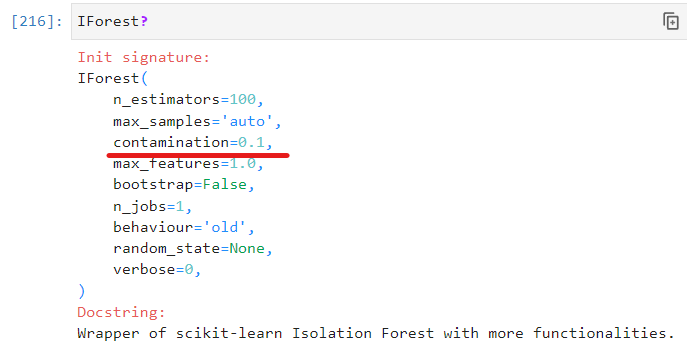

Basically, outlier classifiers are saying to us, "Here is how anomalous I think each sample is. For now, I will select the 10% of most anomalous samples as outliers but you can always change that with my contamination parameter".

Basically, `contamination` is a hyperparameter of all classifiers that controls the number of produced outliers.

Now, this may seem paradoxical - we want to detect outliers using classifiers but classifiers are letting us decide how we choose those outliers. That right there is the biggest challenge of outlier detection.

You, the machine learning engineer, is behind the wheel - you make all the decisions. YOU have to decide what percentage to set for contamination using your experience, domain knowledge, intuition and trial and error. 

### Probability confidence

If finding the right value for contamination sounds hard, there is a workaround that enables us to ditch contamination. And the workaround is outlier probability scores.

Once a PyOD estimator is fit to a dataset, it will have `predict_proba` method available. It returns two columns for each sample, the first column is the probability of the sample being an inlier and the second is the probability of the sample being an outlier. Let's call those inlier probability and outlier probability for short.

In [14]:
from pyod.models.iforest import IForest

iforest = IForest(n_estimators=1000).fit(X)

probs = iforest.predict_proba(X)
probs[:5]

array([[0.6309838 , 0.3690162 ],
       [0.48315014, 0.51684986],
       [0.3044389 , 0.6955611 ],
       [0.73513599, 0.26486401],
       [0.59298752, 0.40701248]])

These probabilities are generated by normalizing the `decision_scores_` array using MinMax scaling, also called normalization.

Normalizing an array will force it to be within the range of 0 and 1, which means we can interpret anomaly scores as probabilities of samples being an outlier. So, here is how `predict_proba` is written under the hood:

In [18]:
from sklearn.preprocessing import minmax_scale

# Create an empty array with two columns
probs = np.empty((len(X), 2))

# The second column is outlier probabilities
probs[:, 1] = minmax_scale(iforest.decision_scores_)

# The first column is inlier probabilities
probs[:, 0] = 1 - probs[:, 1]

# Check if the probs match
probs[:5] == iforest.predict_proba(X)[:5]

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True]])

Now, instead of selecting outliers on the basis of contamination, we can select them on the basis of probability confidence. Instead of choosing 10% of most anomalous samples, we can choose samples that have at least 80%, 90% or n% outlier probability. Here is how it would look like:

In [19]:
# Set a confidence threshold
threshold = 0.9

# Create a mask that returns True if probs over threshold
is_outlier = probs[:, 1] > threshold
outliers_X_probs = X[is_outlier]

# Count up the outliers
num_outliers = len(outliers_X_probs)
print(f"The number of outliers: {num_outliers}")
print(f"Percentage of outliers: {num_outliers / len(X):.4f}")

The number of outliers: 12
Percentage of outliers: 0.0002


Using the probability confidence method, we only find 12 outliers, instead of over 5000. And the best part is that we are 90% sure those 12 outliers are actually outliers!

### How to choose the right probability threshold?

Choosing a probability threshold depends on several factors like dataset size, the task you are trying to solve and the business domain.

If you have a small dataset, you want to make absolutely sure the outliers you are isolating are actually outliers. By dropping them, you don't want to lose important information and patterns in your small dataset which will inevitably affect machine learning models. For such cases, you should set a high threshold like 80-90%.

If you are dealing with sensitive data like medical records where it is critical to avoid false positives, you should aim for over 90%. 95% and 99% are pretty common as well.

It all depends on how confident about outliers you want or must be while solving the business problem with the data at hand.

### How to choose the right outlier classifier

In a supervised-learning task, your job would be easy. You would evaluate a bunch of algorithms using metrics like RMSE or accuracy and choose the one that looks most promising.

However, since outlier detection is an unsupervised-learning problem, you won't really be able to compare one algorithm to another because you can't measure their performance with metrics. 

However, there are some algorithms that consistently perform well if used correctly.

1. [Isolation Forest](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.iforest): works on almost any type of dataset but specifically designed for high-dimensional, complex ones. Even though it is a collection of different variety of decision trees, called ITrees, it is fast and has a high performance. It can also handle data with irregular, non-normal distributions.

2. [Local Outlier Factor](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.lof): particularly good for datasets with datapoints that are clustered together as it calculates anomaly scores using local density. It works well with high-dimensional data and can be faster than IForest.

If you want to learn more about how to choose the right classifier, check out [my Anomaly Detection course on DataCamp](https://app.datacamp.com/learn/courses/anomaly-detection-in-python) where I teach close to 10 outlier classifiers, how and when to use them and how to tune their hyperparameters.

Also, [this page](https://pyod.readthedocs.io/en/latest/pyod.models.html#) of PyOD documentation lists over 40 algorithms. You can see how they perform by looking at this [table](https://pyod.readthedocs.io/en/latest/benchmark.html) where they list the performance of 10 best outlier classifiers on more than 15 datasets. 



### Conclusion

This article covered the topic of multivariate outlier detection in machine learning and demonstrated how it can be done using PyOD in Python. By transforming anomaly scores into probability confidence, selecting the best outlier classifier, and determining the right probability threshold, you can enhance your machine learning models by removing outliers from the data. With this knowledge, you are now ready to perform efficient outlier detection in your own projects.